In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

In [ ]:
# !pip install -U torchvision
# !pip install -U pycocotools
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),  # Resize to a fixed size to reduce memory load
            A.RandomBrightnessContrast(p=0.2),  # Adjust brightness & contrast
            A.GaussianBlur(p=0.2),  # Slight blurring to help generalization
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize for stability
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

    else:  # For validation/testing
        transform = A.Compose([
            A.Resize(512, 512),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

    return transform

In [ ]:
class DOTADETECTION(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "DOTA_1.5.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]


    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, "images", path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        h, w, _ = image.shape

        normalized_boxes = []
        for box in boxes:
            x_min = box[0] / w
            y_min = box[1] / h
            x_max = (box[0] + box[2]) / w
            y_max = (box[1] + box[3]) / h
            normalized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min, box[4]])

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=normalized_boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        denormalized_boxes = []
        for box in boxes:
            x_min = box[0] * w
            y_min = box[1] * h
            x_max = (box[0] + box[2]) * w
            y_max = (box[1] + box[3]) * h
            denormalized_boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.tensor(denormalized_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] + 1 for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/MyDrive/dota_dataset"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "DOTA_1.5.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=7.73s)
creating index...
index created!


{1: {'id': 1, 'name': 'plane', 'supercategory': 'plane'},
 2: {'id': 2, 'name': 'baseball-diamond', 'supercategory': 'baseball-diamond'},
 3: {'id': 3, 'name': 'bridge', 'supercategory': 'bridge'},
 4: {'id': 4,
  'name': 'ground-track-field',
  'supercategory': 'ground-track-field'},
 5: {'id': 5, 'name': 'small-vehicle', 'supercategory': 'small-vehicle'},
 6: {'id': 6, 'name': 'large-vehicle', 'supercategory': 'large-vehicle'},
 7: {'id': 7, 'name': 'ship', 'supercategory': 'ship'},
 8: {'id': 8, 'name': 'tennis-court', 'supercategory': 'tennis-court'},
 9: {'id': 9, 'name': 'basketball-court', 'supercategory': 'basketball-court'},
 10: {'id': 10, 'name': 'storage-tank', 'supercategory': 'storage-tank'},
 11: {'id': 11,
  'name': 'soccer-ball-field',
  'supercategory': 'soccer-ball-field'},
 12: {'id': 12, 'name': 'roundabout', 'supercategory': 'roundabout'},
 13: {'id': 13, 'name': 'harbor', 'supercategory': 'harbor'},
 14: {'id': 14, 'name': 'swimming-pool', 'supercategory': 'swimm

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['plane',
 'baseball-diamond',
 'bridge',
 'ground-track-field',
 'small-vehicle',
 'large-vehicle',
 'ship',
 'tennis-court',
 'basketball-court',
 'storage-tank',
 'soccer-ball-field',
 'roundabout',
 'harbor',
 'swimming-pool',
 'helicopter',
 'container-crane']

In [ ]:
train_dataset = DOTADETECTION(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=3.51s)
creating index...
index created!


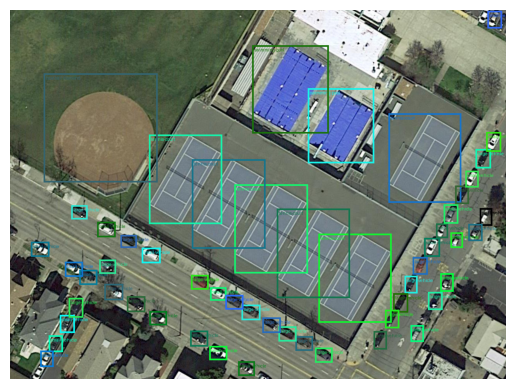

In [ ]:
sample = train_dataset[0]

image_tensor = (sample[0] * 255).to(torch.uint8)

boxes = sample[1]['boxes']
labels = [classes[i.item()-2] for i in sample[1]['labels']]

boxed_image = draw_bounding_boxes(image_tensor, boxes, labels, width=4)

plt.imshow(boxed_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
len(train_dataset)
# print("Labels in dataset:", set([ann['category_id'] for ann in coco.anns.values()]))

1410

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
print(in_features, n_classes)

In [ ]:
# model = models.detection.ssd300_vgg16(weights=None, num_classes=n_classes)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


In [ ]:
model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

in_mask_features = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_mask_features, hidden_layer, n_classes)

print(f"✅ Mask R-CNN model ready with {n_classes} classes!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 69.7MB/s]


✅ Mask R-CNN model ready with 16 classes!


In [ ]:
dataset_yaml = """
path: /content/drive/MyDrive/dota_dataset/
train: train/images
val:
test:

nc: 16
names: ["plane", "baseball-diamond", "bridge", "ground-track-field", "small-vehicle", "large-vehicle", "ship", "tennis-court", "basketball-court", "storage-tank", "soccer-ball-field", "roundabout", "harbor", "swimming-pool", "helicopter", "container-crane"]
"""
# Save the dataset.yaml file
with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml created successfully!")

✅ dataset.yaml created successfully!


In [ ]:
model = YOLO("yolo11n.pt")

model.train(data="dataset.yaml", epochs=10, imgsz=640, device="cuda", batch=4)

Ultralytics 8.3.85 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

train: Scanning /content/drive/MyDrive/dota_dataset/train/labels... 1410 images, 1 backgrounds, 2 corrupt: 100%|██████████| 1411/1411 [12:19<00:00,  1.91it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dota_dataset/train/images/P0334.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0565      1.0583]
train: WARNING ⚠️ /content/drive/MyDrive/dota_dataset/train/images/P1872.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.2618      2.2437      2.1674      2.0553      2.0337      2.0154      1.9993       1.998      1.9395      1.8671      1.8864      1.9115      1.9278      2.0144      1.8735      1.8425       1.822      1.8034      1.7907      1.7744      1.7483       1.723      1.6903      1.8182      1.6506      1.6087
      2.2772      2.2118      1.6596       2.178       2.667      2.7528      2.7749      2.4934      2.4721      2.5177      2.5772        2.64       2.818      2.8019      2.8344      2.8832      2.8976      2.8004      2.7511      2.6603      2.6152      2.5574      2.4091      2.3637      2.2918      2.3171
      2.2527       2.097      2.1098      1.

train: New cache created: /content/drive/MyDrive/dota_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


FileNotFoundError: [34m[1mval: [0mError loading data from None
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [ ]:
# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k:v for k, v in t.items()} for t in targets]
# output = model(images, targets)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, nesterov=True, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
import sys

In [ ]:
import gc

def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def train_one_epoch_frcnn(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    torch.autograd.set_detect_anomaly(True)

    all_losses = []
    all_losses_dict = []

    for i, (images, targets) in enumerate(tqdm(loader)):
        try:
            images = [image.to(device) for image in images]
            targets = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in targets]

            for target in targets:
                target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64).to(device)
                target["labels"] -= 2

                if target["labels"].min() < 0 or target["labels"].max() >= n_classes:
                    print(f"⚠️ Skipping batch {i} due to invalid labels: {target['labels']}")
                    raise ValueError("Invalid label range.")

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
            loss_value = losses.item()

            if not math.isfinite(loss_value):
                print(f"⚠️ Skipping batch {i} due to NaN loss: {loss_dict}")
                raise ValueError("NaN loss detected.")

            all_losses.append(loss_value)
            all_losses_dict.append(loss_dict_append)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            del images, targets, loss_dict, losses
            free_memory()

        except RuntimeError as e:
            if "CUDA" in str(e):
                print(f"\n⚠️ Skipping batch {i} due to CUDA error: {e}")
                free_memory()
                continue
            else:
                print(f"\n⚠️ Unexpected error in batch {i}: {e}")
                raise e

        except ValueError as e:
            print(f"\n⚠️ Skipping batch {i}: {e}")
            free_memory()
            continue

    if all_losses_dict:
        all_losses_dict = pd.DataFrame(all_losses_dict)
        print("\n\n\n Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
        ))
    else:
        print(f"Epoch {epoch} finished, but all batches were skipped due to errors.")

    if epoch % 3 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path+ "epoch-"+str(epoch)+".pth")
        print(f"📌 Model saved at epoch {epoch}")

In [ ]:
torch.save(model.state_dict(), checkpoint_path + "frcnn_weights.pth")

torch.save(model, checkpoint_path + "frcnn.pth")

In [ ]:
def train_one_epoch_ssd(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    torch.autograd.set_detect_anomaly(True)

    all_losses = []

    for i, (images, targets) in enumerate(tqdm(loader)):
        try:
            images = [image.to(device) for image in images]
            targets = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in targets]

            for target in targets:
                target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64).to(device)
                target["labels"] -= 2

                if target["labels"].min() < 0 or target["labels"].max() >= n_classes:
                    print(f"⚠️ Skipping batch {i} due to invalid labels: {target['labels']}")
                    raise ValueError("Invalid label range.")

            loss_dict = model(images, targets)  # SSD returns a dictionary of losses
            loss = loss_dict["classification"] + loss_dict["bbox_regression"]  # Sum both losses

            loss_value = loss.item()

            if not math.isfinite(loss_value):
                print(f"⚠️ Skipping batch {i} due to NaN loss.")
                raise ValueError("NaN loss detected.")

            all_losses.append(loss_value)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del images, targets, loss, loss_dict
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "CUDA" in str(e):
                print(f"\n⚠️ Skipping batch {i} due to CUDA error: {e}")
                torch.cuda.empty_cache()
                continue
            else:
                print(f"\n⚠️ Unexpected error in batch {i}: {e}")
                raise e

        except ValueError as e:
            print(f"\n⚠️ Skipping batch {i}: {e}")
            torch.cuda.empty_cache()
            continue

    if all_losses:
        print(f"\nEpoch {epoch}, lr: {optimizer.param_groups[0]['lr']:.6f}, Loss: {np.mean(all_losses):.6f}")
    else:
        print(f"Epoch {epoch} finished, but all batches were skipped due to errors.")

    if epoch % 3 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f"checkpoint_epoch_{epoch}.pth")
        print(f"📌 Model saved at epoch {epoch}")

In [ ]:
torch.save(model.state_dict(), checkpoint_path + "ssd_weights.pth")

torch.save(model, checkpoint_path + "ssd.pth")

In [ ]:
num_epochs=10
checkpoint_path = "/content/drive/MyDrive/dota_dataset/models/"

import time
start_time = time.time()

for epoch in range(num_epochs):
    train_one_epoch_frcnn(model, optimizer, train_loader, device, epoch)

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Training time: {elapsed_time:.2f} seconds")

  0%|          | 1/353 [00:05<30:36,  5.22s/it]


⚠️ Skipping batch 0 due to CUDA error: CUDA out of memory. Tried to allocate 17.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 12.62 GiB is free. Process 19685 has 2.12 GiB memory in use. Of the allocated memory 1.46 GiB is allocated by PyTorch, and 535.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 2/353 [00:11<33:52,  5.79s/it]


⚠️ Skipping batch 2 due to CUDA error: CUDA out of memory. Tried to allocate 14.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 5.40 GiB is free. Process 19685 has 9.33 GiB memory in use. Of the allocated memory 7.97 GiB is allocated by PyTorch, and 1.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 3/353 [00:20<42:46,  7.33s/it]


⚠️ Skipping batch 3 due to CUDA error: CUDA out of memory. Tried to allocate 8.44 GiB. GPU 0 has a total capacity of 14.74 GiB of which 5.40 GiB is free. Process 19685 has 9.33 GiB memory in use. Of the allocated memory 4.64 GiB is allocated by PyTorch, and 4.55 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 7/353 [00:48<41:21,  7.17s/it]


⚠️ Skipping batch 6 due to CUDA error: CUDA out of memory. Tried to allocate 15.59 GiB. GPU 0 has a total capacity of 14.74 GiB of which 7.11 GiB is free. Process 19685 has 7.62 GiB memory in use. Of the allocated memory 4.73 GiB is allocated by PyTorch, and 2.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 9/353 [01:02<40:53,  7.13s/it]


⚠️ Skipping batch 8 due to CUDA error: CUDA out of memory. Tried to allocate 16.61 GiB. GPU 0 has a total capacity of 14.74 GiB of which 11.01 GiB is free. Process 19685 has 3.73 GiB memory in use. Of the allocated memory 1.33 GiB is allocated by PyTorch, and 2.27 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 9/353 [01:09<44:24,  7.75s/it]


KeyboardInterrupt: 

In [ ]:
checkpoint_file = checkpoint_path + "epoch 5.pth"

In [ ]:
checkpoint = torch.load(checkpoint_file, map_location=torch.device('cuda'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"✅ Model loaded from epoch {checkpoint['epoch']}")

In [ ]:
# model.eval()
# torch.cuda.empty_cache()

import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
test_dataset = DOTADETECTION(root=dataset_path, split="train", transforms=get_transforms(False))

loading annotations into memory...
Done (t=2.12s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

AssertionError: targets should not be none when in training mode

In [ ]:
# fig = plt.figure(figsize=(14, 10))
# plt.imshow(draw_bounding_boxes(img_int,
#     pred['boxes'][pred['scores'] > 0.8],
#     [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
# ).permute(1, 2, 0))